In [1]:
!pip install numpy matplotlib Pillow scikit-learn scikit-image


In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim


In [3]:

def preprocess_image(image_path, size=(64, 64)):
    """Load an image, convert it to grayscale, resize it, and flatten it."""
    img = imread(image_path)
    img_gray = rgb2gray(img)
    img_resized = resize(img_gray, size, anti_aliasing=True)
    img_flattened = img_resized.flatten()
    return img_flattened / 255.0  # Normalize pixel values

def compare_images(original, reconstructed, components, size=(64, 64)):
    """Display a comparison of original and reconstructed images."""
    plt.figure(figsize=(20, 4))
    for i, num in enumerate(components):
        ax = plt.subplot(2, len(components), i + 1)
        plt.imshow(original.reshape(size), cmap='gray')
        ax.set_title(f'Original\n{num} PCs')  # Corrected format
        ax.axis('off')

        ax = plt.subplot(2, len(components), i + 1 + len(components))
        plt.imshow(reconstructed[i].reshape(size), cmap='gray')
        ax.set_title(f'Reconstructed\n{num} PCs')  # Corrected format
        ax.axis('off')
    plt.show()


def perform_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.show()
    return pca


In [4]:
def load_and_save_images(directory, output_dir, size=(64, 64), batch_size=100):
    images = []
    batch_index = 0
    for i, filename in enumerate(os.listdir(directory)):
        if filename.endswith(".jpg"):  # Assuming all images are in JPG format
            img_path = os.path.join(directory, filename)
            img = preprocess_image(img_path, size)
            images.append(img)
            if (i + 1) % batch_size == 0:
                batch_data = np.array(images)
                np.save(os.path.join(output_dir, f'batch_{batch_index}.npy'), batch_data)
                images = []
                batch_index += 1
    if images:  # Save any remaining images
        np.save(os.path.join(output_dir, f'batch_{batch_index}.npy'), np.array(images))

# Directory to save processed batches
output_path = r"C:\Users\user\OneDrive\Desktop\output"

# Directory containing the original data
data_path = r"C:\Users\user\OneDrive\Desktop\data hw d\data\data"

# Call the function to process and save images
load_and_save_images(data_path, output_path)


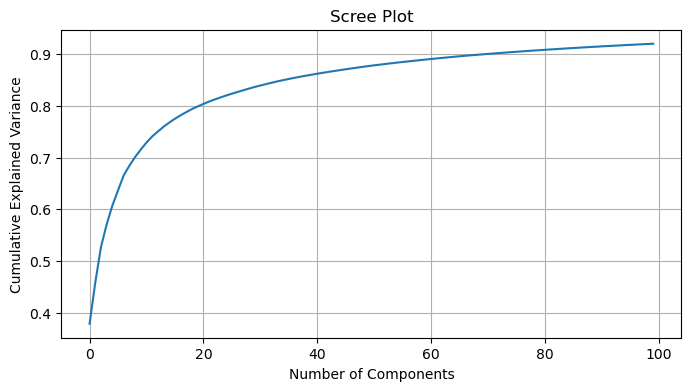

PCA fitting is complete


In [5]:
all_data = []
sample_size = 10000  # Adjust the size to fit in your memory

for batch_file in os.listdir(output_path):
    if batch_file.endswith('.npy'):
        data = np.load(os.path.join(output_path, batch_file))
        # Randomly sample the data
        indices = np.random.choice(data.shape[0], min(sample_size, data.shape[0]), replace=False)
        sampled_data = data[indices]
        all_data.append(sampled_data)
        if sum(d.shape[0] for d in all_data) >= sample_size:
            break  # Stop once we have enough samples

all_data = np.concatenate(all_data, axis=0)

# Fit PCA and display scree plot
pca = perform_pca(all_data, n_components=100)
print("PCA fitting is complete")


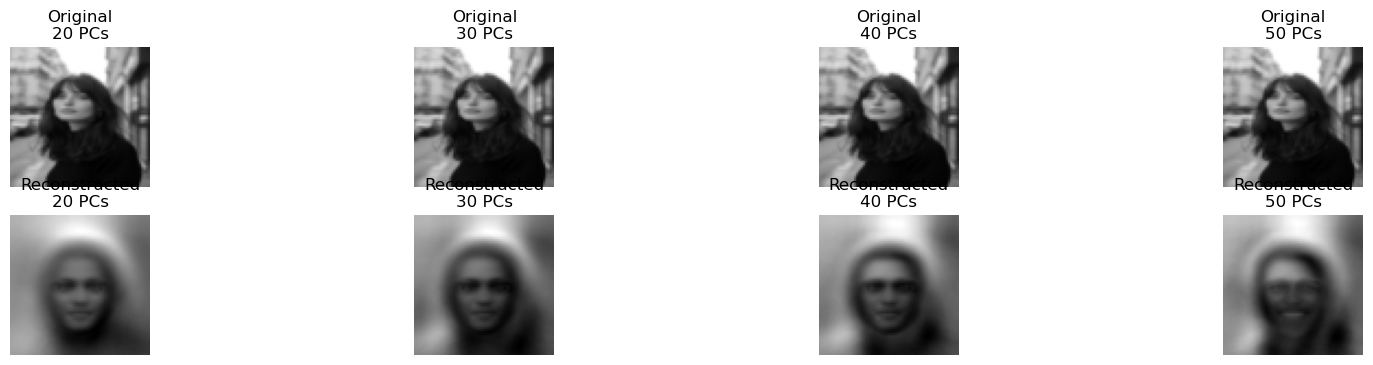

In [6]:
def reconstruct_and_compare_faces(image_path, pca, components=[20, 30, 40, 50]):
    img = preprocess_image(image_path).reshape(1, -1)
    reconstructions = []
    for n in components:
        pca_n = PCA(n_components=n)
        pca_n.fit(all_data)
        transformed_img = pca_n.transform(img)
        reconstructed_img = pca_n.inverse_transform(transformed_img)
        reconstructions.append(reconstructed_img)
    compare_images(img, reconstructions, components)

# Path to your image
my_image_path = r"C:\Users\user\Downloads\girl photo.jpg"
reconstruct_and_compare_faces(my_image_path, pca)


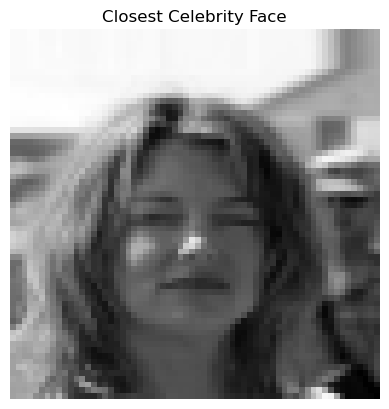

In [7]:
from sklearn.metrics.pairwise import euclidean_distances

def find_closest_face(my_image_path, all_data, pca):
    my_image_vector = preprocess_image(my_image_path, (64, 64)).reshape(1, -1)
    my_face_pca = pca.transform(my_image_vector)
    all_faces_pca = pca.transform(all_data)

    distances = euclidean_distances(my_face_pca, all_faces_pca)
    closest_index = np.argmin(distances)
    closest_face = all_data[closest_index].reshape(64, 64)
    
    plt.imshow(closest_face, cmap='gray')
    plt.axis('off')
    plt.title("Closest Celebrity Face")
    plt.show()

# Path to your image
my_image_path = r"C:\Users\user\Downloads\girl photo.jpg"
find_closest_face(my_image_path, all_data, pca)


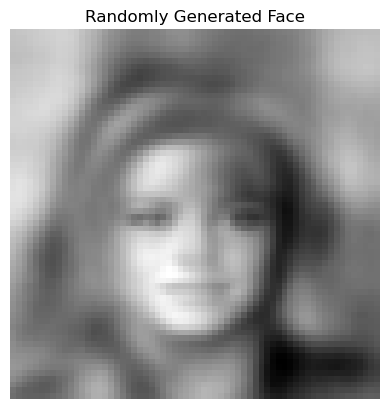

In [57]:
def generate_random_face(pca, size=(64, 64), percentile=95):
    # Calculate the magnitude of principal components
    principal_components_magnitude = np.linalg.norm(pca.components_, axis=1)
    controlled_range = np.percentile(principal_components_magnitude, percentile)

    # Use variance of each component to scale the random coefficients
    coeffs_variance = np.sqrt(pca.explained_variance_)
    scaling_factors = np.minimum(coeffs_variance, controlled_range)  # Limit the influence of each component
    random_coeffs = np.random.normal(0, scaling_factors, (1, pca.n_components))
    
    # Project the manipulated vectors back to the original data space
    random_face = pca.inverse_transform(random_coeffs)
    
    plt.imshow(random_face.reshape(size), cmap='gray')
    plt.axis('off')
    plt.title("Randomly Generated Face")
    plt.show()

generate_random_face(pca)

In [58]:
def calculate_mse_and_ssim(all_data, pca):
    reconstructed_data = pca.inverse_transform(pca.transform(all_data))
    mse = np.mean((all_data - reconstructed_data) ** 2)
    # Calculate SSIM for each pair of original and reconstructed images for more insights
    ssim_values = [ssim(orig.reshape(64, 64), recon.reshape(64, 64), data_range=1.0) for orig, recon in zip(all_data, reconstructed_data)]
    average_ssim = np.mean(ssim_values)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Average SSIM: {average_ssim}")

calculate_mse_and_ssim(all_data, pca)


Mean Squared Error: 9.184870394262755e-08
Average SSIM: 0.9998401904278813
